In [1]:
print('Importing all libraries')
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from tensorflow import keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Activation,Flatten,Dropout
from tensorflow.keras.layers import Conv2D,MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers

import cv2, IPython, PIL, time
from io import BytesIO

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory


# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Importing all libraries


In [2]:
datagen = ImageDataGenerator (
            rescale = 1./255, 
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            )
images_dir = './New Masks Dataset/'
print('Files found')

Files found


In [3]:
# load the data using data generators
print('Training set')
train_generator  =    datagen.flow_from_directory(
                             images_dir + 'Train',
                             seed=42,
                             target_size = (200,200),
                             batch_size =64 ,               
                             class_mode = 'binary',
                            )

print('Test set')
test_generator = datagen.flow_from_directory(
                             images_dir + 'Test' ,
                             seed=42, 
                             target_size = (200,200),
                             batch_size = 64 ,               
                             class_mode = 'binary',
                            )

print('Validation set')
validation_generator = datagen.flow_from_directory(
                             images_dir + 'Validation' ,
                             seed=42, 
                             target_size = (200,200),
                             batch_size = 64 ,               
                             class_mode = 'binary',
                            )

Training set
Found 600 images belonging to 2 classes.
Test set
Found 111 images belonging to 2 classes.
Validation set
Found 306 images belonging to 2 classes.


In [4]:
from tensorflow.keras.layers import Dense,Activation,Flatten,Dropout
from tensorflow.keras.layers import Conv2D,MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint

model=Sequential()

model.add(Conv2D(32,(3,3),input_shape=(200,200,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
#The first CNN layer followed by Relu and MaxPooling layers

model.add(Conv2D(64,(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
#The second convolution layer followed by Relu and MaxPooling layers

model.add(Flatten())
model.add(Dropout(0.5))
#Flatten layer to stack the output convolutions from second convolution layer
model.add(Dense(128,activation='relu'))
#Dense layer of 128 neurons
model.add(Dense(2,activation='softmax'))
#The Final layer with two outputs for two categories

# model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics=['accuracy'])
print('Model defnined')

Model defnined


In [5]:
H = model.fit(
        train_generator,
        epochs = 5,
        validation_data = validation_generator,
        shuffle=True,)
# https://www.tensorflow.org/tutorials/keras/save_and_load

Epoch 1/5
10/10 [==============================] - 22s 2s/step - loss: 4.7128 - accuracy: 0.5474 - val_loss: 0.4294 - val_accuracy: 0.8497
Epoch 2/5
10/10 [==============================] - 20s 2s/step - loss: 0.3908 - accuracy: 0.8463 - val_loss: 0.3584 - val_accuracy: 0.8529
Epoch 3/5
10/10 [==============================] - 22s 2s/step - loss: 0.2616 - accuracy: 0.9023 - val_loss: 0.2603 - val_accuracy: 0.8954
Epoch 4/5
10/10 [==============================] - 20s 2s/step - loss: 0.2381 - accuracy: 0.9120 - val_loss: 0.2595 - val_accuracy: 0.9052
Epoch 5/5
10/10 [==============================] - 20s 2s/step - loss: 0.1956 - accuracy: 0.9380 - val_loss: 0.3361 - val_accuracy: 0.8627


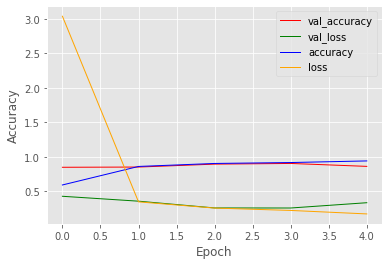

In [6]:
from matplotlib import pyplot as plt
plt.style.use('ggplot')
plots = ['val_accuracy','val_loss', 'accuracy', 'loss']
co = ['red','green','blue', 'orange']
cu = 0
for what in plots:
    y1 = []
    for x in H.history[what]:
        y1.append(x)
    plt.plot(H.epoch, y1, color=co[cu],linewidth = 1, label = what)
    cu +=1
plt.xlabel('Epoch') 
plt.ylabel('Accuracy') 
plt.legend() 
plt.show() 


In [7]:
import cv2
import time
def image_resize(image, width = None, height = None, inter = cv2.INTER_AREA):
    # initialize the dimensions of the image to be resized and
    # grab the image size
    dim = None
    (h, w) = image.shape[:2]

    # if both the width and height are None, then return the
    # original image
    if width is None and height is None:
        return image

    # check to see if the width is None
    if width is None:
        # calculate the ratio of the height and construct the
        # dimensions
        r = height / float(h)
        dim = (int(w * r), height)

    # otherwise, the height is None
    else:
        # calculate the ratio of the width and construct the
        # dimensions
        r = width / float(w)
        dim = (width, int(h * r))

    # resize the image
    resized = cv2.resize(image, dim, interpolation = inter)

    # return the resized image
    return resized


In [8]:
def image_reshape(image, dimension=200):

    image = image_resize(image, height=dimension)
    (h, w, c) = image.shape
    offset = int((w-dimension)/2)
    image = image[0:dimension, offset:dimension+offset, 0:c]
    return image
    

In [9]:
def get_frame(cam):
    # Capture frame-by-frame
    ret, frame = cam.read()

    #flip image for natural viewing
    frame = cv2.flip(frame, 1)

    return frame
#Use 'jpeg' instead of 'png' (~5 times faster)
def array_to_image(a, fmt='jpeg'):
    #Create binary stream object
    f = BytesIO()

    #Convert array to binary stream object
    PIL.Image.fromarray(a).save(f, fmt)

    return IPython.display.Image(data=f.getvalue())

In [23]:
from tensorflow.keras.preprocessing import image
cam = cv2.VideoCapture(1)

d = IPython.display.display("", display_id=1)
d2 = IPython.display.display("", display_id=2)
while True:
    try:
        t1 = time.time()
        frame = get_frame(cam)
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame = image_reshape(frame, dimension=200)
        
        result = model.predict(frame.reshape(1,200,200,3))
        if result[0][0] > .5:
            prediction = 'mask'
        else :
            prediction = 'unmask'

        im = array_to_image(frame)
        d.update(im)

        t2 = time.time()

#         s = f"""{int(1/(t2-t1))} FPS"""
        d2.update( IPython.display.HTML(prediction) )
    except KeyboardInterrupt:
        print()
        cam.release()
        IPython.display.clear_output()
        print ("Stream stopped")
        break

Stream stopped


In [11]:
frame.shape

(200, 200, 3)

In [14]:
frame.shape

(200, 200, 3)

In [15]:
test_image.shape

NameError: name 'test_image' is not defined

In [20]:
result = model.predict(frame.reshape(1,200,200,3))
if result[0][0] > .5:
    prediction = 'mask'
else :
    prediction = 'unmask'
print(prediction)

unmask


In [19]:
print(result)

[[0. 1.]]


In [16]:
# EXAMPLE

#For Predicting on single Image
from tensorflow.keras.preprocessing import image
# test_image = image.load_img('New Masks Dataset/Test/Mask/2300.png', target_size = (200,200,3))
test_image = image.load_img('New Masks Dataset/Test/Non Mask/real_01081.jpg', target_size = (200,200,3))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
result = model.predict(test_image)
print(result[0])
if result[0][0] > .5:
    prediction = 'mask'
else :
    prediction = 'unmask'
print(prediction)

[0. 1.]


In [17]:
test_image.shape

(1, 200, 200, 3)

In [ ]:
# from cv2 import *
# camera = cv2.VideoCapture(1)

# while cv2.waitKey(1) != 27:
#     _, image = camera.read()
#     cv2.imshow("",image)
    

In [ ]:
# \print(image.load_img('New Masks Dataset/Test/Non Mask/real_01081.jpg'))

In [ ]:
# #For Prediction using WebCam (Will not work on Kraggle only on local Jupyter Notebook)

# import cv2 
# face_clsfr=cv2.CascadeClassifier('Downloads/haarscade_frontalface_default.xml') # to detect the face (need to download it)


In [ ]:

# labels_dict={0:'NO Mask',1:'Mask'}
# color_dict={0:(0,255,0),1:(0,0,255)}

# size = 4
# webcam = cv2.VideoCapture(0) #Use camera 0

# # We load the xml file
# classifier = cv2.CascadeClassifier('../haarcascade_frontalface_default.xml')

# while True:
#     (rval, im) = webcam.read()
#     im=cv2.flip(im,1,1) #Flip to act as a mirror

#     # Resize the image to speed up detection
#     mini = cv2.resize(im, (im.shape[1] // size, im.shape[0] // size))

#     # detect MultiScale / faces 
#     faces = classifier.detectMultiScale(mini)

#     # Draw rectangles around each face
#     for f in faces:
#         (x, y, w, h) = [v * size for v in f] #Scale the shapesize backup
#         #Save just the rectangle faces in Face_img
#         face_img = im[y:y+h, x:x+w] 
#         cv2.imwrite('temp.jpg',face_img)
#         test_image=image.load_img('temp.jpg',target_size=(200,200,3))
#         test_image=image.img_to_array(test_image)
#         test_image=np.expand_dims(test_image,axis=0)
#         result=model.predict(test_image)
#         answer = model.predict_classes(test_image)
#         train_generator.class_indices
#         if result[0][0]==1:
#             prediction = 1
#         else :
#             prediction = 0
#         print(prediction)
#         print(result)
        
#         label=np.argmax(result,axis=1)[0]
      
#         cv2.rectangle(im,(x,y),(x+w,y+h),color_dict[label],2)
#         cv2.rectangle(im,(x,y-40),(x+w,y),color_dict[label],-1)
#         cv2.putText(im, labels_dict[prediction], (x, y-10),cv2.FONT_HERSHEY_SIMPLEX,0.8,(255,255,255),2)
        
#     # Show the image
#     cv2.imshow('LIVE',   im)
#     key = cv2.waitKey(10)
#     # if Esc key is press then break out of the loop 
#     if key == 27: #The Esc key
#         break
# # Stop video
# webcam.release()

# # Close all started windows
# cv2.destroyAllWindows()

# Testing

In [ ]:
# ! ls ..

In [ ]:
# webcam = cv2.VideoCapture(0) #Use camera 0

In [ ]:
# print(webcam)
# webcam.isOpened()

In [ ]:
# (rval, im) = webcam.read()
# im=cv2.flip(im,1,1) #Flip to act as a mirror

# # Resize the image to speed up detection
# mini = cv2.resize(im, (im.shape[1] // size, im.shape[0] // size))

In [ ]:
# print(mini)

In [ ]:
# print(im)

In [ ]:
# dir(webcam)

In [ ]:
# import ipywidgets

In [ ]:

# labels_dict={0:'NO Mask',1:'Mask'}
# color_dict={0:(0,255,0),1:(0,0,255)}

# size = 4
# webcam = cv2.VideoCapture(0) #Use camera 0

# # We load the xml file
# classifier = cv2.CascadeClassifier('../haarcascade_frontalface_default.xml')

# while True:
#     (rval, im) = webcam.read()
#     im=cv2.flip(im,1,1) #Flip to act as a mirror

#     # Resize the image to speed up detection
#     mini = cv2.resize(im, (im.shape[1] // size, im.shape[0] // size))

#     # detect MultiScale / faces 
#     faces = classifier.detectMultiScale(mini)

#     # Draw rectangles around each face
#     for f in faces:
#         (x, y, w, h) = [v * size for v in f] #Scale the shapesize backup
#         #Save just the rectangle faces in Face_img
#         face_img = im[y:y+h, x:x+w] 
#         cv2.imwrite('temp.jpg',face_img)
#         test_image=image.load_img('temp.jpg',target_size=(200,200,3))
#         test_image=image.img_to_array(test_image)
#         test_image=np.expand_dims(test_image,axis=0)
#         result=model.predict(test_image)
#         answer = model.predict_classes(test_image)
#         train_generator.class_indices
#         if result[0][0]==1:
#             prediction = 1
#         else :
#             prediction = 0
#         print(prediction)
#         print(result)
        
#         label=np.argmax(result,axis=1)[0]
      
#         cv2.rectangle(im,(x,y),(x+w,y+h),color_dict[label],2)
#         cv2.rectangle(im,(x,y-40),(x+w,y),color_dict[label],-1)
#         cv2.putText(im, labels_dict[prediction], (x, y-10),cv2.FONT_HERSHEY_SIMPLEX,0.8,(255,255,255),2)
        
#     # Show the image
#     cv2.imshow('LIVE',   im)
#     key = cv2.waitKey(10)
#     # if Esc key is press then break out of the loop 
#     if key == 27: #The Esc key
#         break
# # Stop video
# webcam.release()

# # Close all started windows
# cv2.destroyAllWindows()